In [ ]:
pip install matplotlib

Random Seed:  1552
Files already downloaded and verified
[0/25][0/782] Loss_D: 1.7839 Loss_G: 4.4898 D(x): 0.3991 D(G(z)): 0.4712 / 0.0138
[0/25][100/782] Loss_D: 2.4137 Loss_G: 32.6159 D(x): 0.4427 D(G(z)): 0.0000 / 0.0000
[0/25][200/782] Loss_D: 0.6173 Loss_G: 6.8708 D(x): 0.8730 D(G(z)): 0.3067 / 0.0026
[0/25][300/782] Loss_D: 0.0995 Loss_G: 8.6224 D(x): 0.9275 D(G(z)): 0.0029 / 0.0016
[0/25][400/782] Loss_D: 0.3534 Loss_G: 9.5642 D(x): 0.9133 D(G(z)): 0.1563 / 0.0001
[0/25][500/782] Loss_D: 0.1766 Loss_G: 6.0178 D(x): 0.9520 D(G(z)): 0.1105 / 0.0031
[0/25][600/782] Loss_D: 0.3414 Loss_G: 4.3273 D(x): 0.8268 D(G(z)): 0.0577 / 0.0256
[0/25][700/782] Loss_D: 0.5941 Loss_G: 3.7362 D(x): 0.7525 D(G(z)): 0.1520 / 0.0538
[1/25][0/782] Loss_D: 0.2725 Loss_G: 5.2385 D(x): 0.9684 D(G(z)): 0.1998 / 0.0079
[1/25][100/782] Loss_D: 1.4403 Loss_G: 5.4129 D(x): 0.7349 D(G(z)): 0.4704 / 0.0132
[1/25][200/782] Loss_D: 0.1356 Loss_G: 4.7185 D(x): 0.9365 D(G(z)): 0.0636 / 0.0133
[1/25][300/782] Loss_D

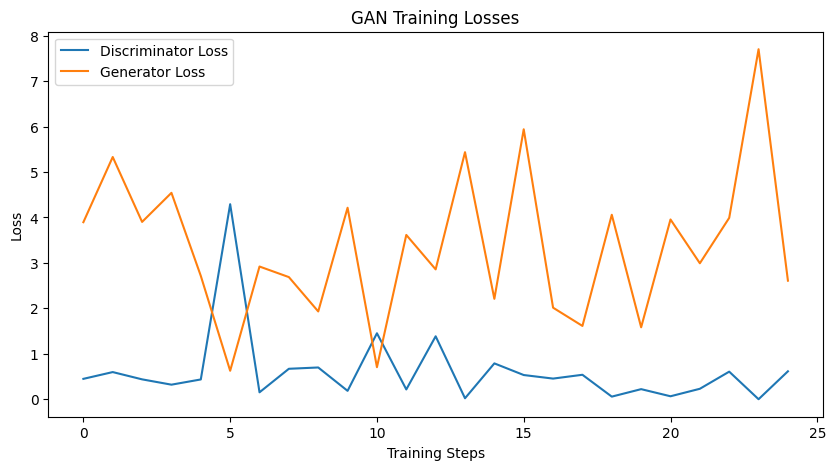

In [1]:
from __future__ import print_function
import os
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F



class opt:
    dataset = 'cifar10'  # cifar10 | lsun | mnist | imagenet | folder | lfw | fake
    dataroot = 'data'  # path to dataset
    workers = 2  # number of data loading workers
    batch_size = 64  # input batch size
    image_size = 64  # the height / width of the input image to network
    nz = 100  # size of the latent z vector
    ngf = 64  # default value for ngf
    ndf = 64  # default value for ndf
    niter = 25  # number of epochs to train for
    lr = 0.0002  # learning rate, default=0.0002
    beta1 = 0.5  # beta1 for adam, default=0.5
    cuda = True  # enables cuda
    dry_run = False  # check a single training cycle works
    ngpu = 1  # number of GPUs to use
    netG = ''  # path to netG (to continue training)
    netD = ''  # path to netD (to continue training)
    outf = 'result'  # folder to output images and model checkpoints
    manualSeed = None  # manual seed
    mps = False  # enables macOS GPU training

try:
    os.makedirs(opt.outf)
except OSError:
    pass

if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000)
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

cudnn.benchmark = True

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

if torch.backends.mps.is_available() and not opt.mps:
    print("WARNING: You have mps device, to enable macOS GPU run with --mps")

if opt.dataroot is None and str(opt.dataset).lower() != 'fake':
    raise ValueError("`dataroot` parameter is required for dataset \"%s\"" % opt.dataset)

if opt.dataset in ['imagenet', 'folder', 'lfw']:
    # folder dataset
    dataset = dset.ImageFolder(root=opt.dataroot,
                               transform=transforms.Compose([
                                   transforms.Resize(opt.image_size),
                                   transforms.CenterCrop(opt.image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
    nc = 3
elif opt.dataset == 'lsun':
    classes = [c + '_train' for c in opt.classes.split(',')]
    dataset = dset.LSUN(root=opt.dataroot, classes=classes,
                        transform=transforms.Compose([
                            transforms.Resize(opt.image_size),
                            transforms.CenterCrop(opt.image_size),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ]))
    nc = 3
elif opt.dataset == 'cifar10':
    dataset = dset.CIFAR10(root=opt.dataroot, download=True,
                           transform=transforms.Compose([
                               transforms.Resize(opt.image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
    nc = 3

elif opt.dataset == 'mnist':
    dataset = dset.MNIST(root=opt.dataroot, download=True,
                         transform=transforms.Compose([
                             transforms.Resize(opt.image_size),
                             transforms.ToTensor(),
                             transforms.Normalize((0.5,), (0.5,)),
                         ]))
    nc = 1

elif opt.dataset == 'fake':
    dataset = dset.FakeData(image_size=(3, opt.image_size, opt.image_size),
                            transform=transforms.ToTensor())
    nc = 3

assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size,
                                         shuffle=True, num_workers=int(opt.workers))
use_mps = opt.mps and torch.backends.mps.is_available()
if opt.cuda:
    device = torch.device("cuda:0")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

ngpu = int(opt.ngpu)
nz = int(opt.nz)
ngf = int(opt.ngf)
ndf = int(opt.ndf)


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.apply(weights_init)
if opt.netG != '':
    netG.load_state_dict(torch.load(opt.netG))
# print(netG)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
if opt.netD != '':
    netD.load_state_dict(torch.load(opt.netD))
# print(netD)

def dcgan_loss(real_output, fake_output, is_discriminator=True, ema=None, it=None):
    """
    Computes the loss for the DCGAN model based on whether it's used for the
    discriminator or generator.

    Args:
        real_output (torch.Tensor): The discriminator output for real images.
        fake_output (torch.Tensor): The discriminator output for fake images generated by the generator.
        is_discriminator (bool): If True, computes loss for the discriminator.
                                 If False, computes loss for the generator.

    Returns:
        torch.Tensor: The computed loss.
    """
    # Use Binary Cross-Entropy Loss
    loss_fn = nn.BCELoss()

    if is_discriminator:
        if ema is not None:
            # track the prediction
            ema.update(torch.mean(fake_output).item(), 'D_fake', it)
            ema.update(torch.mean(real_output).item(), 'D_real', it)
        # For discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        real_labels = torch.ones_like(real_output)
        fake_labels = torch.zeros_like(fake_output)
        real_loss = loss_fn(real_output, real_labels)
        fake_loss = loss_fn(fake_output, fake_labels)
        return real_loss, fake_loss
    else:
        # For generator: maximize log(D(G(z)))
        real_labels = torch.ones_like(fake_output)  # Target as real for generator loss
        return loss_fn(fake_output, real_labels)

class ema_losses:
    def __init__(self, init=1000., decay=0.9, start_itr=0):
        self.G_loss = init
        self.D_loss_real = init
        self.D_loss_fake = init
        self.D_real = init
        self.D_fake = init
        self.decay = decay
        self.start_itr = start_itr

    def update(self, cur, mode, itr):
        if itr < self.start_itr:
            decay = 0.0
        else:
            decay = self.decay
        if mode == 'G_loss':
          self.G_loss = self.G_loss*decay + cur*(1 - decay)
        elif mode == 'D_loss_real':
          self.D_loss_real = self.D_loss_real*decay + cur*(1 - decay)
        elif mode == 'D_loss_fake':
          self.D_loss_fake = self.D_loss_fake*decay + cur*(1 - decay)
        elif mode == 'D_real':
          self.D_real = self.D_real*decay + cur*(1 - decay)
        elif mode == 'D_fake':
          self.D_fake = self.D_fake*decay + cur*(1 - decay)


def lecam_reg(dis_real, dis_fake, ema):
    import torch.nn.functional as F
    reg = torch.mean(F.relu(dis_real - ema.D_fake).pow(2)) + \
            torch.mean(F.relu(ema.D_real - dis_fake).pow(2))
    return reg

lecam_ratio = 0
ema_losses = ema_losses(start_itr=100)

fixed_noise = torch.randn(opt.batch_size, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))

if opt.dry_run:
    opt.niter = 1
def train_step(dataloader, ema_losses, device, G_loss_total):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
    
        # Train with real
        real_output = netD(real_cpu)
        D_x = real_output.mean().item()
        # Generate fake images
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        fake_output = netD(fake.detach())
        real_loss, fake_loss = dcgan_loss(real_output, fake_output, is_discriminator=True, ema=ema_losses, it=i)
        if lecam_ratio > 0 and i > ema_losses.start_itr:
            loss_LC = lecam_reg(real_loss, fake_loss, ema_losses) * lecam_ratio
        else:
            loss_LC = torch.tensor(0.)
        d_loss = real_loss + fake_loss + loss_LC
        d_loss.backward()
        D_G_z1 = fake_output.mean().item()
        optimizerD.step()
    
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        fake_output = netD(fake)
        g_loss = dcgan_loss(None, fake_output, is_discriminator=False)
        g_loss.backward()
        D_G_z2 = fake_output.mean().item()
        G_loss_total += g_loss.item()
        optimizerG.step()
    
        # Accumulation
        ema_losses.update(G_loss_total, 'G_loss', i)
        # Logging (optional)
        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch, opt.niter, i, len(dataloader),
                     d_loss.item(), g_loss.item(), D_x, D_G_z1, D_G_z2))
    return d_loss.item(), g_loss.item(), real_cpu, netG

import matplotlib.pyplot as plt

# Initialize lists to store loss values
d_losses = []
g_losses = []


for epoch in range(opt.niter):
    G_loss_total = 0
    d_loss, g_loss, real_cpu, netG = train_step(dataloader, ema_losses, device, G_loss_total)
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    vutils.save_image(real_cpu,
                      '%s/real_samples.png' % opt.outf,
                      normalize=True)
    fake = netG(fixed_noise)
    vutils.save_image(fake.detach(),
                      '%s/fake_samples_epoch_%03d.png' % (opt.outf, epoch),
                      normalize=True)

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Training Losses")
plt.show()

In [2]:
from PIL import Image, ImageDraw, ImageFont
import os

def is_image_file(filename):
    """Check if the file is an image by extension."""
    image_extensions = {".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff"}
    return os.path.splitext(filename)[1].lower() in image_extensions

def create_gif_from_folder(folder_path, output_gif_path, duration=1000, loop=0):
    """
    Create a GIF from images in a folder, with each frame displaying the image's filename.
    
    Args:
        folder_path (str): Path to the folder containing images.
        output_gif_path (str): Path to save the generated GIF.
        duration (int): Duration in milliseconds for each frame.
        loop (int): Number of loops for the GIF (0 for infinite).
    """
    images = []
    
    # Sort files to ensure a specific order, if needed
    for filename in sorted(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, filename)
        
        # Check if the file is an image
        if is_image_file(filename):
            try:
                img = Image.open(file_path).convert("RGB")  # Ensure image is in RGB mode
                draw = ImageDraw.Draw(img)
                
                # Optional: Load a custom font (requires a .ttf font file)
                # font = ImageFont.truetype("arial.ttf", 20)  # Adjust path and size as needed
                
                # Draw filename at the bottom of the image
                text = filename
                text_width, text_height = draw.textsize(text)
                position = ((img.width - text_width) // 2, img.height - text_height - 10)
                draw.text(position, text, fill="white")  # Use `font=font` if using a custom font

                images.append(img)
            except IOError:
                print(f"Warning: Could not open image file {file_path}")
    
    if images:
        # Save as GIF
        images[0].save(
            output_gif_path, 
            save_all=True, 
            append_images=images[1:], 
            duration=duration, 
            loop=loop
        )
        print(f"GIF created successfully and saved at {output_gif_path}")
    else:
        print("No valid images found in the folder.")

# Example usage
folder_path = "result"
output_gif_path = "output.gif"
create_gif_from_folder(folder_path, output_gif_path)


/tmp/ipykernel_10934/2806360814.py:36: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text)
/tmp/ipykernel_10934/2806360814.py:36: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text)
/tmp/ipykernel_10934/2806360814.py:36: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text)
/tmp/ipykernel_10934/2806360814.py:36: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text)
/tmp/ipykernel_10934/2806360814.py:36: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or tex

GIF created successfully and saved at output.gif
